# For halo 0 of each sim, graph and save the model

Loaded simulation in 6.13 seconds.
3309.3396858119663 2943.410026039886 3391.2707381054133
Got X and Y in 7.76 seconds.


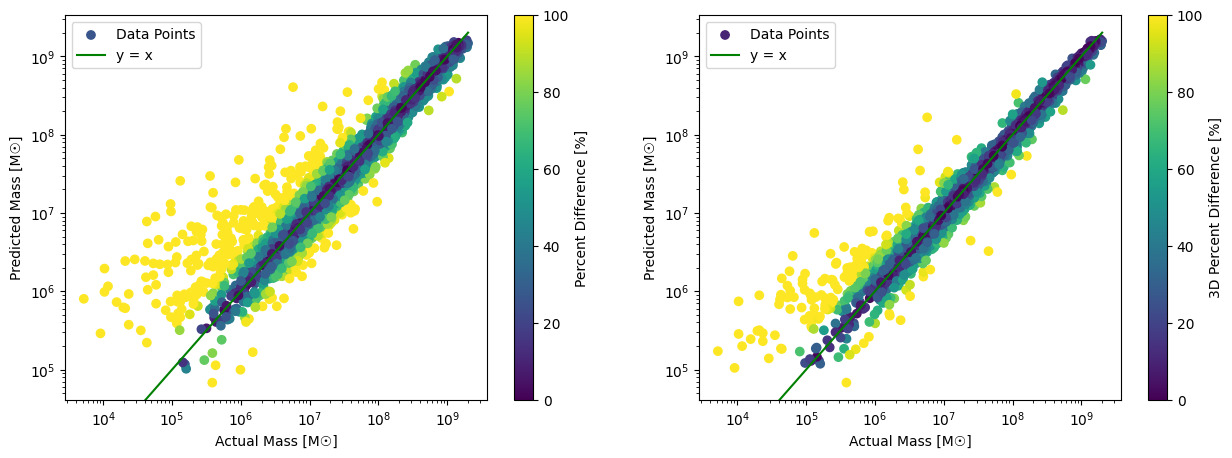

<Figure size 1500x500 with 0 Axes>

In [1]:
import numpy as np, joblib, time
from graph import graph, graph2, graph3, graph4
from sklearn.model_selection import train_test_split 
from stellarutil import Simulation
from sklearn.neighbors import KNeighborsRegressor 
from IPython.display import clear_output

def split_data(X, Y, test_size=0.2, random_state=42):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    X_TRAIN = np.array(X_train) 
    Y_TRAIN = np.array(Y_train)
    X_TEST = np.array(X_test)
    Y_TEST = np.array(Y_test)
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST

def processSim(sim_name: str):
    X = []
    Y = []
    X2 = []
    Y2 = []
    start = time.time()
    sim = Simulation(simulation_name=sim_name, species=['star', 'dark'])
    clear_output()
    print(f'Loaded simulation in {round(time.time()-start,2)} seconds.')
    # Get the x,y,z positions of each dm particle in the simulation, normalize it with halo center
    dark_x = sim.particles['dark']['position'][:,0]
    dark_y = sim.particles['dark']['position'][:,1]
    dark_z = sim.particles['dark']['position'][:,2]
    # Get the mass of each dm particle in the simulation
    DM_MASS = 1303.0022
    # Get the halo and restrict
    halo = sim.get_halo(0)
    halo.restrict_percentage(15)
    print(halo.xc, halo.yc, halo.zc)
    # Get the x,y,z positions of each dm particle in the simulation, normalize it with halo center
    halo_dark_x = dark_x - halo.xc
    halo_dark_y = dark_y - halo.yc
    halo_dark_z = dark_z - halo.zc
    # Get the distance of each dm particle from the center of the indicated dark matter halo
    halo_dark_distances = np.sqrt(np.square(halo_dark_x) + np.square(halo_dark_y) + np.square(halo_dark_z))
    halo_dark_distances = np.sort(halo_dark_distances)
    
    # Get X and Y for 2D models
    for star in halo.stars:
        X.append([star.x, star.y, star.vz, star.a, star.get_3DR(), star.get_3DR(), star.get_3DR()])
        # X.append([star.x, star.y, star.vz, star.a, star.get_2DR(), star.get_2DR(), star.get_2DR(),star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y])
        count = np.searchsorted(halo_dark_distances, star.get_2DR())
        Y.append(count * DM_MASS)
    print(f'Got X and Y in {round(time.time() - start,2)} seconds.')

    # Get X2 and Y2 for 3D models
    for star in halo.stars:
        # X.append([star.x, star.y, star.vz, star.a, star.get_2DR(), star.get_2DR(), star.get_2DR()])
        X2.append([star.x, star.y, star.vz, star.a, star.get_3DR(), star.get_3DR(), star.get_3DR(),star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y])
        count = np.searchsorted(halo_dark_distances, star.get_3DR())
        Y2.append(count * DM_MASS)

    # Save X and Y in pickle files
    # joblib.dump(X,f'../data/pickle/{sim_name}_X_halo_0.pkl')
    # joblib.dump(Y,f'../data/pickle/{sim_name}_Y_halo_0.pkl')


    # Split the data
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = split_data(X, Y)
    X_TRAIN2, X_TEST2, Y_TRAIN2, Y_TEST2 = split_data(X2, Y2)


    # Create the KNN Regressor, train, and then predict
    knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn_regressor.fit(X_TRAIN, Y_TRAIN)
    Y_PRED = np.array(knn_regressor.predict(X_TEST))

    knn_regressor2 = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn_regressor2.fit(X_TRAIN2, Y_TRAIN2)
    Y_PRED2 = np.array(knn_regressor2.predict(X_TEST2))
    
    
    # Save the model
    # joblib.dump(knn_regressor, f"../data/pickle/model_{sim_name}.pkl")

    # Graph the results
    # x = [star[0] for star in X_TEST]
    # y = [star[1] for star in X_TEST]
    c = np.zeros(len(Y_TEST))
    non_zero_indices = np.logical_and(Y_TEST != 0, Y_PRED != 0)
    c[non_zero_indices] = (np.abs(Y_TEST[non_zero_indices] - Y_PRED[non_zero_indices]) / ((Y_TEST[non_zero_indices] + Y_PRED[non_zero_indices]) / 2)) * 100

    c2 = np.zeros(len(Y_TEST2))
    non_zero_indices = np.logical_and(Y_TEST2 != 0, Y_PRED2 != 0)
    c2[non_zero_indices] = (np.abs(Y_TEST2[non_zero_indices] - Y_PRED2[non_zero_indices]) / ((Y_TEST2[non_zero_indices] + Y_PRED2[non_zero_indices]) / 2)) * 100


    # graph(x, y, c, sim_name,Y_TEST, Y_PRED)
    # Graph the results with two groups
    radius = [star[4] for star in X_TEST]
    # graph2(radius, Y_PRED, radius, Y_TEST, sim_name)
    # Graph the results for GalFRESCA
    # graph3(radius, Y_PRED, radius, Y_TEST, sim_name, Y_TEST, Y_PRED, c)

    graph4(sim_name, Y_TEST, Y_PRED, c, Y_TEST2, Y_PRED2, c2)

names = ['m10q_res250md', 'm10r_res250md', 'm10v_res250md', 'm10v_res030md']
# names = ['m10q_res250md', 'm10r_res250md', 'm10v_res250md']
# names = ['m10v_res030md']
names = ['m10q_res250md']

for name in names:
    processSim(name)


# Train Model Sigma on the same training stars

In [ ]:
from sklearn.neighbors import KNeighborsRegressor 
import joblib, numpy as np


X_BV = joblib.load('../data/pickle/m10v_res030md_X_halo_0.pkl')
Y_BV = joblib.load('../data/pickle/m10v_res030md_Y_halo_0.pkl')
X_LV = joblib.load('../data/pickle/m10v_res250md_X_halo_0.pkl')
Y_LV = joblib.load('../data/pickle/m10v_res250md_Y_halo_0.pkl')
X_LR = joblib.load('../data/pickle/m10r_res250md_X_halo_0.pkl')
Y_LR = joblib.load('../data/pickle/m10r_res250md_Y_halo_0.pkl')
X_LQ = joblib.load('../data/pickle/m10q_res250md_X_halo_0.pkl')
Y_LQ = joblib.load('../data/pickle/m10q_res250md_Y_halo_0.pkl')                   

# Train on the same stars used to train the other models
X_TRAIN_BV, X_TEST_BV, Y_TRAIN_BV, Y_TEST_BV = split_data(X_BV, Y_BV)
X_TRAIN_LV, X_TEST_LV, Y_TRAIN_LV, Y_TEST_LV = split_data(X_LV, Y_LV)
X_TRAIN_LR, X_TEST_LR, Y_TRAIN_LR, Y_TEST_LR = split_data(X_LR, Y_LR)
X_TRAIN_LQ, X_TEST_LQ, Y_TRAIN_LQ, Y_TEST_LQ = split_data(X_LQ, Y_LQ)

X_TRAIN = np.concatenate((X_TRAIN_BV, X_TRAIN_LR, X_TRAIN_LQ))
Y_TRAIN = np.concatenate((Y_TRAIN_BV, Y_TRAIN_LR, Y_TRAIN_LQ))
# X_TRAIN = np.concatenate((X_TRAIN_LQ, X_TRAIN_BV))
# Y_TRAIN = np.concatenate((Y_TRAIN_LQ, Y_TRAIN_BV))
# X_TRAIN = X_TRAIN_BV
# Y_TRAIN = Y_TRAIN_BV

# Create the KNN Regressor, train, and then predict
model_sigma = KNeighborsRegressor(n_neighbors=5)
model_sigma.fit(X_TRAIN, Y_TRAIN)
# Save the big boy model
joblib.dump(model_sigma, "../data/pickle/model_sigma.pkl")

# Test the model on different sims

# BV
Y_PRED_BV = np.array(model_sigma.predict(X_TEST_BV))
# Graph the results
x = [star[0] for star in X_TEST_BV]
y = [star[1] for star in X_TEST_BV]
c = (np.abs(Y_TEST_BV - Y_PRED_BV) / ((Y_TEST_BV + Y_PRED_BV) / 2)) * 100
graph(x, y, c, "m10v_res030md model sigma",Y_TEST_BV, Y_PRED_BV)
radius = [star[4] for star in X_TEST_BV]
graph2(radius, Y_PRED_BV, radius, Y_TEST_BV, "m10v_res030md model sigma curve")

# Gal FRESA graph
graph3(radius, Y_PRED_BV, radius, Y_TEST_BV, "m10v_res030md", Y_TEST_BV, Y_PRED_BV, c)

# LV
Y_PRED_LV = np.array(model_sigma.predict(X_TEST_LV))
# Graph the results
x = [star[0] for star in X_TEST_LV]
y = [star[1] for star in X_TEST_LV]
c = np.zeros(len(Y_TEST_LV))
non_zero_indices = np.logical_and(Y_TEST_LV != 0, Y_PRED_LV != 0)
c[non_zero_indices] = (np.abs(Y_TEST_LV[non_zero_indices] - Y_PRED_LV[non_zero_indices]) / ((Y_TEST_LV[non_zero_indices] + Y_PRED_LV[non_zero_indices]) / 2)) * 100
graph(x, y, c, "m10v_res250md model sigma",Y_TEST_LV, Y_PRED_LV)
radius = [star[4] for star in X_TEST_LV]
graph2(radius, Y_PRED_LV, radius, Y_TEST_LV, "m10v_res250md model sigma curve")

# LR
Y_PRED_LR = np.array(model_sigma.predict(X_TEST_LR))
# Graph the results
x = [star[0] for star in X_TEST_LR]
y = [star[1] for star in X_TEST_LR]
c = (np.abs(Y_TEST_LR - Y_PRED_LR) / ((Y_TEST_LR + Y_PRED_LR) / 2)) * 100
graph(x, y, c, "m10r_res250md model sigma",Y_TEST_LR, Y_PRED_LR)
radius = [star[4] for star in X_TEST_LR]
graph2(radius, Y_PRED_LR, radius, Y_TEST_LR, "m10r_res250md model sigma curve")

# LQ
Y_PRED_LQ = np.array(model_sigma.predict(X_TEST_LQ))
# Graph the results
x = [star[0] for star in X_TEST_LQ]
y = [star[1] for star in X_TEST_LQ]
c = (np.abs(Y_TEST_LQ - Y_PRED_LQ) / ((Y_TEST_LQ + Y_PRED_LQ) / 2)) * 100
graph(x, y, c, "m10q_res250md model sigma",Y_TEST_LQ, Y_PRED_LQ)
radius = [star[4] for star in X_TEST_LQ]
graph2(radius, Y_PRED_LQ, radius, Y_TEST_LQ, "m10q_res250md model sigma curve")






# ML vs Wolf's Equation at Steller Mass Ratios

In [ ]:
import numpy as np, joblib, bisect
from stellarutil import Simulation
from IPython.display import clear_output

def mlPredictionAtStellarMassRatio(model, halo, stellarMassRatio=0.5):
    # Sort stars by 3D radius, stars closer to the center first
    sorted_stars = sorted(halo.stars, key=lambda star: star.get_2DR())
    # Get the total mass of all stars
    TOTAL_STAR_MASS = np.sum([star.m for star in sorted_stars])
    # Go through stars until half of the mass is enclosed
    enclosed_mass, star_index = 0, 0
    while True:
        enclosed_mass += sorted_stars[star_index].m
        star_index += 1
        if enclosed_mass >= TOTAL_STAR_MASS * stellarMassRatio: break
    
    # radius = sorted_stars[star_index].get_2DR()
    # X = []
    # for i in range(star_index-20, star_index+20):
    #     star = sorted_stars[i]
    #     # X.append([star.x, star.y, star.vz, star.a, star.get_2DR(), star.get_2DR(), star.get_2DR()])
    #     X.append([star.x, star.y, star.vz, star.a, star.get_2DR(), star.get_2DR(), star.get_2DR(),star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y])
    # Predict the star's enclosed dm mass
    # prediction = model.predict(X)
    # return np.mean(prediction), round(radius,2)

    star = sorted_stars[star_index]
    X = [[star.x, star.y, star.vz, star.a, star.get_2DR(), star.get_2DR(), star.get_2DR(),star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y]]
    prediction = model.predict(X)
    return np.mean(prediction)

def mlPredictionAtHaloRadiusRatio(model, halo, haloRadiusRatio=0.5):
    # Sort stars by 3D radius, stars closer to the center first
    sorted_stars = sorted(halo.stars, key=lambda star: star.get_2DR())
    # Find the star nearest to the desired radius
    star_index = 0
    while True:
        if sorted_stars[star_index].get_2DR() >= halo.radius * .15 * haloRadiusRatio: break
        star_index += 1

    star = sorted_stars[star_index]
    # Make the prediction
    X = [[star.x, star.y, star.vz, star.a, star.get_2DR(), star.get_2DR(), star.get_2DR(),star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y,star.x, star.y]]
    prediction = model.predict(X)
    return np.mean(prediction)

def actualTotalMassAtStellarMassRatio(sim, stellarMassRatio=0.5): 
    halo = sim.get_halo(0)
    halo.restrict_percentage(15)
    # Sort stars by 3D radius, stars closer to the center first
    sorted_stars = sorted(halo.stars, key=lambda star: star.get_3DR())
    # Get the total mass of all stars
    TOTAL_STAR_MASS = np.sum([star.m for star in sorted_stars])
    # Go through stars until the desired mass
    desired_mass = TOTAL_STAR_MASS * stellarMassRatio
    enclosed_mass, star_index = 0, 0
    while True:
        enclosed_mass += sorted_stars[star_index].m
        star_index += 1
        if enclosed_mass >= desired_mass: break
    # The radius of the star at star_index is is the x-mass radius
    radius = sorted_stars[star_index].get_3DR()
    # Get the dm masses
    dark_x = sim.particles['dark']['position'][:,0] - halo.xc
    dark_y = sim.particles['dark']['position'][:,1] - halo.yc
    dark_z = sim.particles['dark']['position'][:,2] - halo.zc
    DM_MASS = 1303.0022
    dark_distances = np.sqrt(np.square(dark_x) + np.square(dark_y) + np.square(dark_z))
    dark_distances = np.sort(dark_distances)
    num_dm_particles = bisect.bisect_left(dark_distances, radius)
    return num_dm_particles * DM_MASS

    # Get the star masses
    # star_x = sim.particles['star']['position'][:,0] - halo.xc
    # star_y = sim.particles['star']['position'][:,1] - halo.yc
    # star_z = sim.particles['star']['position'][:,2] - halo.zc
    # star_m = sim.particles['star']['mass']
    # star_distances = np.sqrt(np.square(star_x) + np.square(star_y) + np.square(star_z))
    # star_masses = star_m[star_distances < radius]
    # Get the dm masses
    # dark_x = sim.particles['dark']['position'][:,0] - halo.xc
    # dark_y = sim.particles['dark']['position'][:,1] - halo.yc
    # dark_z = sim.particles['dark']['position'][:,2] - halo.zc
    # dark_m = sim.particles['dark']['mass']
    # dark_distances = np.sqrt(np.square(dark_x) + np.square(dark_y) + np.square(dark_z))
    # dark_masses = dark_m[dark_distances < radius]
    # Get the gas masses
    # gas_x = sim.particles['gas']['position'][:,0] - halo.xc
    # gas_y = sim.particles['gas']['position'][:,1] - halo.yc
    # gas_z = sim.particles['gas']['position'][:,2] - halo.zc
    # gas_m = sim.particles['gas']['mass']
    # gas_distances = np.sqrt(np.square(gas_x) + np.square(gas_y) + np.square(gas_z))
    # gas_masses = gas_m[gas_distances < radius]

    return np.sum(dark_masses)
    # return  np.sum(star_masses) + np.sum(dark_masses) + np.sum(gas_masses)

def actualTotalMassAtHaloRadiusRatio(sim, haloRadiusRatio=0.5): 
    halo = sim.get_halo(0)
    halo.restrict_percentage(15)
    radius = halo.radius * .15 * haloRadiusRatio # PROBLEM HERE WITH M10V_RES250MD
    print(f"Radius is {round(radius,2)} kpc at halo radius ratio {haloRadiusRatio}")

    # Get the dm masses
    dark_x = sim.particles['dark']['position'][:,0] - halo.xc
    dark_y = sim.particles['dark']['position'][:,1] - halo.yc
    dark_z = sim.particles['dark']['position'][:,2] - halo.zc
    DM_MASS = 1303.0022
    dark_distances = np.sqrt(np.square(dark_x) + np.square(dark_y) + np.square(dark_z))
    dark_distances = np.sort(dark_distances)
    num_dm_particles = bisect.bisect_left(dark_distances, radius)
    return num_dm_particles * DM_MASS

def wolfPredictionAtStellarMassRatio(halo, stellarMassRatio=0.5):
    # Sort stars by 3D radius, stars closer to the center first
    sorted_stars = sorted(halo.stars, key=lambda star: star.get_3DR())
    # Get the total mass of all stars
    TOTAL_STAR_MASS = np.sum([star.m for star in sorted_stars])
    # Go through stars until the desired mass
    desired_mass = TOTAL_STAR_MASS * stellarMassRatio
    enclosed_mass, star_index = 0, 0
    while True:
        enclosed_mass += sorted_stars[star_index].m
        star_index += 1
        if enclosed_mass >= desired_mass: break
    # The radius of the star at star_index is is the x-mass radius
    radius = sorted_stars[star_index].get_3DR()
    print(f"Radius is {round(radius,2)} kpc at stellar mass ratio {stellarMassRatio}")
    # Only consider stars within the x-mass radius
    included_stars = sorted_stars[:star_index]
    # Find <σ^2>...
    los_dispersion = np.std([star.vz * star.m for star in included_stars])
    luminosities = [star.m for star in included_stars]
    average = np.average([los_dispersion ** 2] * len(included_stars), weights=luminosities)
    # Plug and chug...
    prediction = 3 * pow(4.3 * 10**-6, -1) * average * radius
    print(TOTAL_STAR_MASS, enclosed_mass, desired_mass, radius, los_dispersion, average, prediction)
    return prediction 


names = ['m10v_res250md']
for name in names:
    model = joblib.load(f"../data/pickle/model_{name}.pkl")
    # Load the simulation
    sim = Simulation(simulation_name=name, species=['star', 'dark'])
    clear_output()
    # Get the halo
    halo = sim.get_halo()
    halo.restrict_percentage(15)
    # Make a prediction for different stellar mass ratios
    ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    ratios = [0.5]
    for ratio in ratios: 
        actual = actualTotalMassAtStellarMassRatio(sim,ratio)
        wolf_prediction = wolfPredictionAtStellarMassRatio(halo,ratio)
        wolf_percent_diff = abs(wolf_prediction - actual) / ((wolf_prediction + actual) / 2) * 100
        ml_prediction = mlPredictionAtStellarMassRatio(model, halo, ratio)
        ml_percent_diff = abs(ml_prediction - actual) / ((ml_prediction + actual) / 2) * 100
        print(f"Actual = {actual:.2e}")
        print(f"Wolf   = {wolf_prediction:.2e}")
        print(f"ML     = {ml_prediction:.2e}")
        print(f"Wolf Percent Difference = {round(wolf_percent_diff)}%")
        print(f"ML Percent Difference   = {round(ml_percent_diff)}%\n")
    # Now do different halo radius ratios
    # print("-" * 20,"Halo Radius Ratios","-" * 20)
    # for ratio in ratios: 
    #     actual = actualTotalMassAtHaloRadiusRatio(sim,ratio)
    #     ml_prediction = mlPredictionAtHaloRadiusRatio(model, halo, ratio)
    #     ml_percent_diff = abs(ml_prediction - actual) / ((ml_prediction + actual) / 2) * 100
    #     print(f"Actual = {actual:.2e}")
    #     print(f"ML     = {ml_prediction:.2e}")
    #     print(f"ML Percent Difference   = {ml_percent_diff:.2f}%\n")
        
        
    # print(TOTAL_STAR_MASS, enclosed_mass, desired_mass, radius, los_dispersion, average, prediction)
  
